In [75]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from scipy.stats import linregress
import statsmodels.api as sm


------

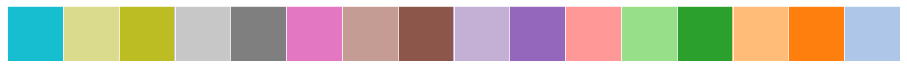

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)

----

# Excercise 2: Moneyball

Moneyball, as well as being a fantastic story, is also a true story of statistical methods being applied in a real world context to make predictions for decision making. [The film Moneyball](https://www.youtube.com/watch?v=-4QPVo0UIzc) is well worth a watch if you have time. As well as in baseball most major competitive sports teams are now using data science to improve their performance, e.g. [football](http://outsideoftheboot.com/2013/06/26/rise-of-data-analysis-in-football/),...

In this excercise you have been hired by Oakland Athletics general manager Billy Beane. Your first mission is to predict the salary each player will make based on other information that is available. This will allow Billy to understand what price he should pay for players in the next transfer season.

You must:
* Import and prepare the data
* Create a train and test set
* Implement a regularised model of your choice (Ridge or Lasso)
* Choose optimal parameters for your regularised model
* Estimate test-error using k-fold cross validation
* Calculate the true test-error
* Run a base line model to compare your model results. Base line model is the most simple approach based on strategy of choice (mean or other). It is then used as reference to conclude whether more complex models are better or not: see DummyRegressor in the sklearn library.

HINT 1
* Some values are missing. You can drop these rows.

HINT 2
* Some columns do not contain numerical values. You can drop these columns. In the Machine Learning model you'll learn more about labeling categorical data

In [174]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    return MSE, RMSE, MAE, MEDAE, R2

In [175]:
def print_shape(df):
    print(f"Samples ---> {df.shape[0]}")
    print(f"Features --> {df.shape[1]}")

In [176]:
def plot_result_alpha(results, name):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,9))
    fig.suptitle("Alpha study for" + name, fontsize=20)
    
    sns.lineplot(
        ax=ax[0],
        x=results["param_alpha"], 
        y=-results["mean_test_score"], 
        data=results,
        color=colors[0],
    )
    
    ax[0].set_ylabel("MSE | STD", fontsize=15)
    ax[0].set_title(f"MSE", fontsize=20)
    
    sns.lineplot(
        ax=ax[1],
        x=results["param_alpha"], 
        y=results["std_test_score"], 
        data=results,
        color=colors[0],
    )
    ax[0].set_xlabel(" ", fontsize=15)
    ax[1].set_xlabel("Alpha", fontsize=15)
    ax[1].set_ylabel("STD", fontsize=15)
    
    fig.subplots_adjust(wspace=10)
    plt.show()

## Import and Prepare

In [177]:
df_hitters = pd.read_csv('./data/hitters.csv')
df_hitters = df_hitters.rename(columns={'Unnamed: 0': 'name'})

In [178]:
print_shape(df_hitters)

Samples ---> 322
Features --> 21


In [179]:
df_hitters.dtypes

name          object
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [180]:
df_hitters = df_hitters.drop(df_hitters.select_dtypes(include=['object']).columns, axis=1)
print_shape(df_hitters)

Samples ---> 322
Features --> 17


In [181]:
df_hitters = df_hitters.dropna()
print_shape(df_hitters)
print("---------------------")
print("On perd 59 samples")

Samples ---> 263
Features --> 17
---------------------
On perd 59 samples


In [182]:
salary = df_hitters.pop("Salary")
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25


<AxesSubplot:>

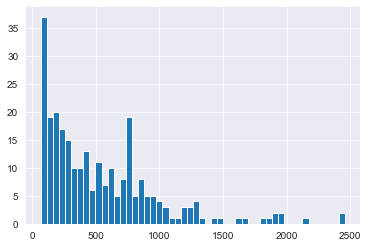

In [183]:
salary.hist(bins=50)

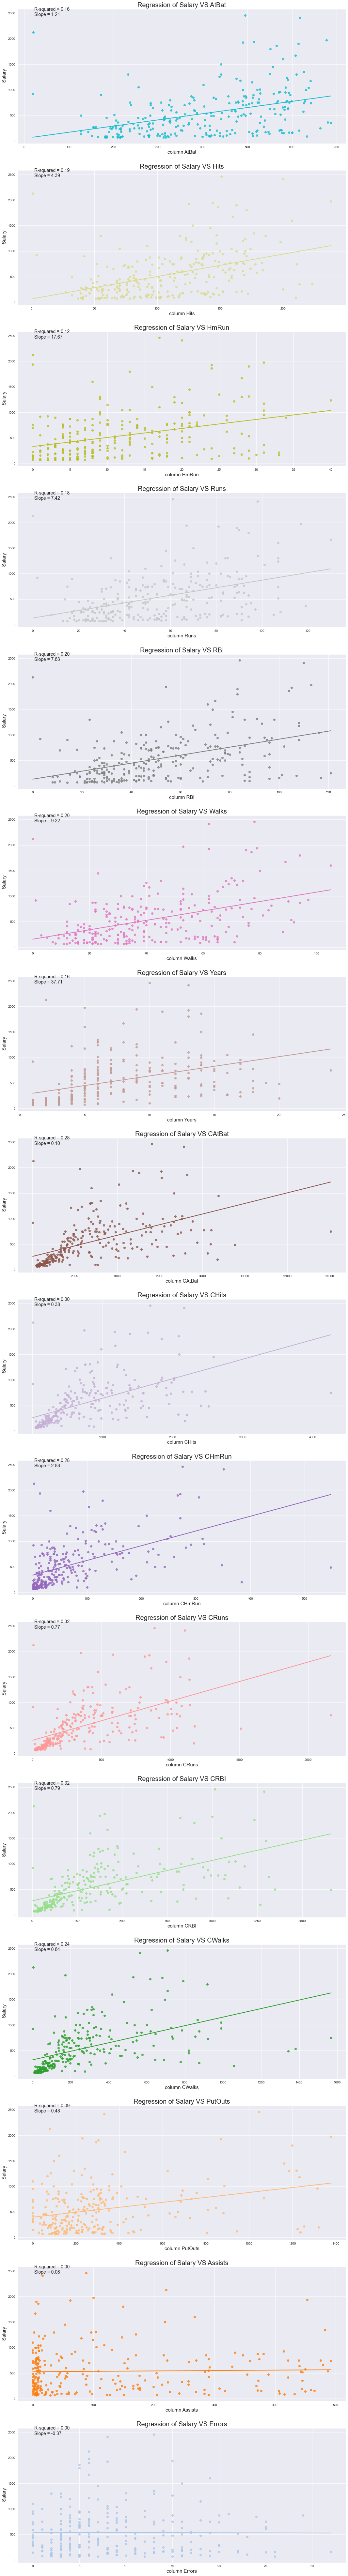

In [184]:
fig, ax = plt.subplots(nrows=len(df_hitters.columns), ncols=1, figsize=(18,9*len(df_hitters.columns)))

for i, col in enumerate(df_hitters.columns):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_hitters[col], salary)
    r_squared = r_value ** 2
    
    sns.regplot(
        ax=ax[i],
        x=col, 
        y=salary, 
        data=df_hitters,
        color=colors[i],
        ci=None
    )
    ax[i].set_xlabel(f"column {col}", fontsize=15)
    ax[i].set_ylabel(f" Salary", fontsize=15)
    ax[i].set_title(f"Regression of Salary VS {col}", fontsize=20)
    ax[i].annotate("R-squared = {:.2f}\nSlope = {:.2f}".format(r_squared, slope),
            xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14)

plt.show()

In [185]:
X_train, X_test, y_train, y_test = train_test_split(df_hitters, salary, random_state = 18)

## KFOLD Regression

In [192]:
def kfold_study(model, X, y, rangeValue):
    cv_list = []
    MSE_list = []
    RMSE_list = []
    for i in range(rangeValue[0], rangeValue[1], rangeValue[2]):
        print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
        print(f"CV ---> {i}")
        crossPrediction = cross_val_predict(model, X, y, cv=i)
        MSE, RMSE, MAE, MEDAE, R2 = compute_indicator(y, crossPrediction)
        cv_list.append(i)
        MSE_list.append(MSE)
        RMSE_list.append(RMSE)
        
    return cv_list, MSE_list, RMSE_list

In [204]:
lasso = Lasso(max_iter=10000)
cv_scores = cross_val_score(lasso, X_train, y_train, cv = 27, scoring='neg_mean_squared_error') 

### Test Lasso on different kfold

In [201]:
cv_list, MSE_list, RMSE_list = kfold_study(lasso, X_train, y_train, [2, 40, 2])

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 2
MSE ----> 161149.92128365842
RMSE ---> 401.4348281896557
MAE ----> 262.951158134894
MEDAE --> 183.6198562034483
R2 -----> 0.24293267871731083
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 4
MSE ----> 150165.39408396246
RMSE ---> 387.51179863839303
MAE ----> 261.4279528349007
MEDAE --> 188.78746803345598
R2 -----> 0.2945369644432262
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 6
MSE ----> 137297.58400868555
RMSE ---> 370.53688616477245
MAE ----> 249.2990036129709
MEDAE --> 180.49134748262702
R2 -----> 0.35498873771661565
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
CV ---> 8
MSE ----> 136033.47125273326
RMSE ---> 368.827156338485
MAE ----> 247.94416690321592
MEDAE --> 175.63897976327553
R2 -----> 0.3609274217092906
°°°°°°°°°°°°°°°°°°°°°°

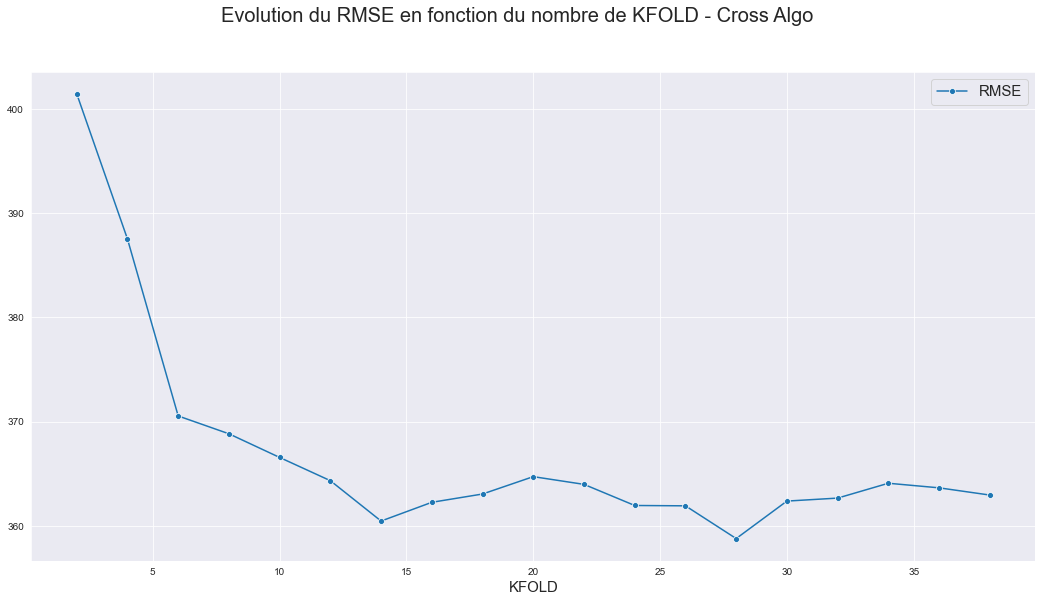

In [202]:
fig, ax = plt.subplots(figsize=(18,9))
fig.suptitle("Evolution du RMSE en fonction du nombre de KFOLD - Cross Algo", fontsize=20)

sns.lineplot(
    x = cv_list, 
    y=RMSE_list,
    label="RMSE",
    linestyle="-",
    marker = "o"
)

ax.set_xlabel("KFOLD", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.legend(fontsize=15)

In [207]:
-cv_scores.mean()

130000.2689910734

## Lasso regression

### Best alpha

In [157]:
def lasso_alpha_test(alphaList):
    lasso = Lasso(max_iter=10000)

    param_grid = [{'alpha': alphaList}]

    grid_search_lasso = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search_lasso.fit(X_train, y_train)

    grid_results_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
    return grid_results_lasso

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018538,0.002210,0.000803,0.000118,0.001,{'alpha': 0.001},-217282.638504,-142431.300189,-38129.220330,-171439.493314,-193651.199210,-111986.735627,-272455.162312,-85456.377730,-64068.275661,-37715.494921,-133461.589780,75714.876011,7
1,0.015590,0.001971,0.000713,0.000136,0.01,{'alpha': 0.01},-217277.362440,-142429.748805,-38128.842776,-171437.840008,-193649.490794,-111982.635704,-272454.774032,-85456.453135,-64067.767423,-37714.912226,-133459.982734,75714.262846,6
2,0.012797,0.001628,0.000652,0.000130,0.1,{'alpha': 0.1},-217224.608701,-142414.247791,-38125.071392,-171421.307375,-193632.418034,-111941.646116,-272450.897400,-85457.216552,-64062.693128,-37709.092975,-133443.919946,75708.132807,5
3,0.010237,0.001351,0.000784,0.000149,1,{'alpha': 1},-216698.213996,-142260.517962,-38087.772834,-171256.241843,-193462.828455,-111532.705177,-272412.745609,-85465.786282,-64012.756637,-37651.668529,-133284.123732,75647.055069,4
4,0.008560,0.001299,0.000664,0.000107,3,{'alpha': 3},-215535.591776,-141927.230172,-38004.103170,-170891.198902,-193093.371372,-111032.512635,-272430.597969,-85490.923764,-63907.033100,-37529.052973,-132984.161583,75519.605248,3
5,0.006764,0.001032,0.000733,0.000141,10,{'alpha': 10},-211544.879322,-140873.662362,-37733.888648,-169638.790536,-191880.642276,-108851.727280,-272683.296116,-85508.250560,-63593.848723,-36948.026484,-131925.701231,75165.110545,2
6,0.004223,0.000599,0.000758,0.000083,100,{'alpha': 100},-192069.568126,-135131.118706,-41933.371965,-170710.058112,-180630.566756,-101494.782801,-271515.250997,-82878.392223,-63854.378516,-30704.100319,-127092.158852,72845.986085,1


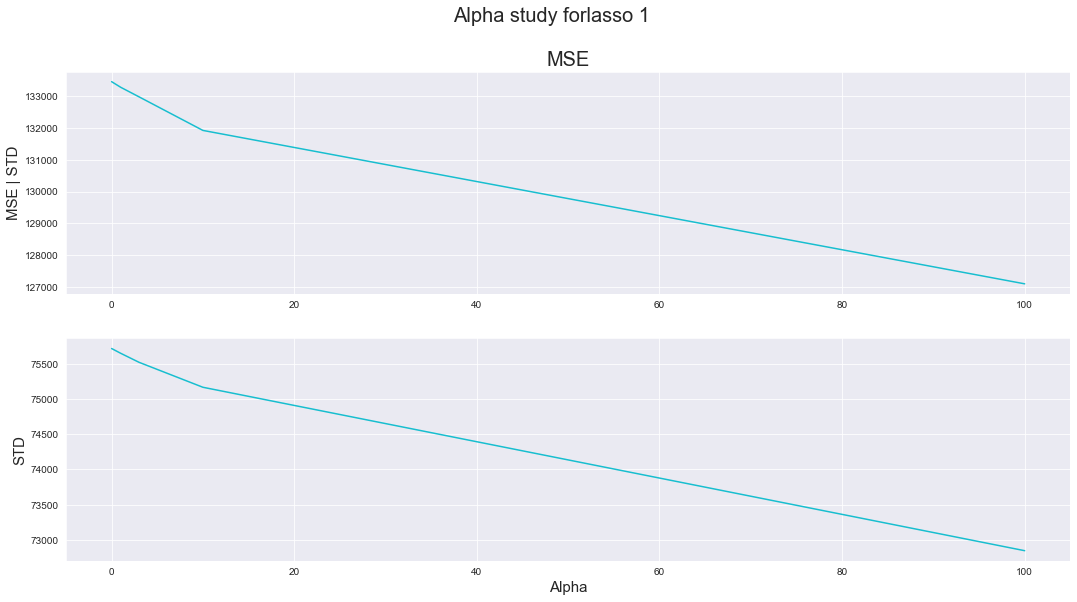

In [156]:
plot_result_alpha(grid_results_lasso, "lasso 1")

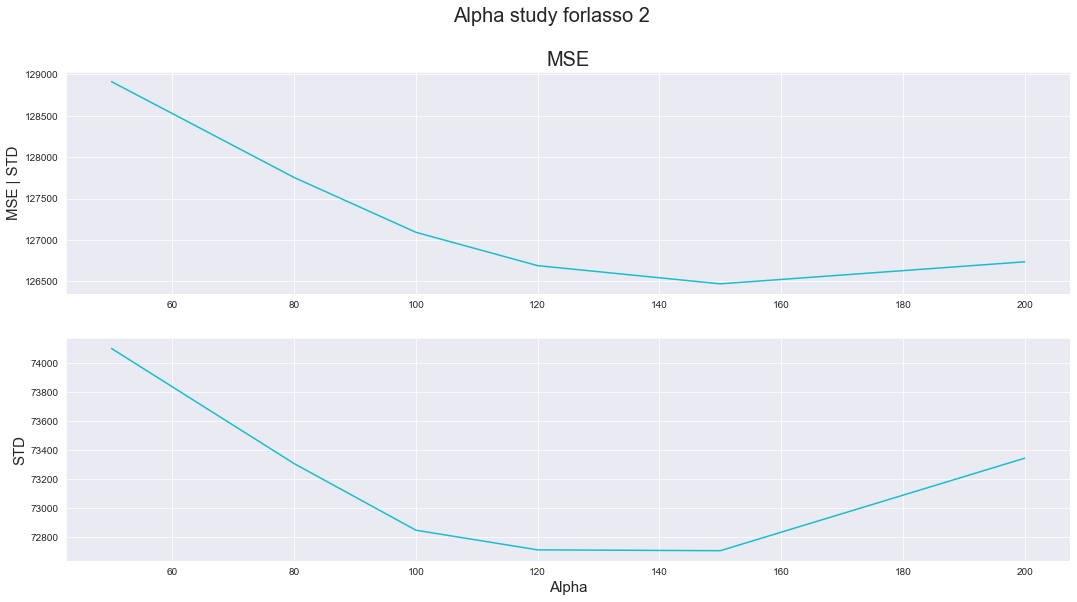

In [160]:
results = lasso_alpha_test([50, 80, 100, 120, 150, 200])
plot_result_alpha(results, "lasso 2")

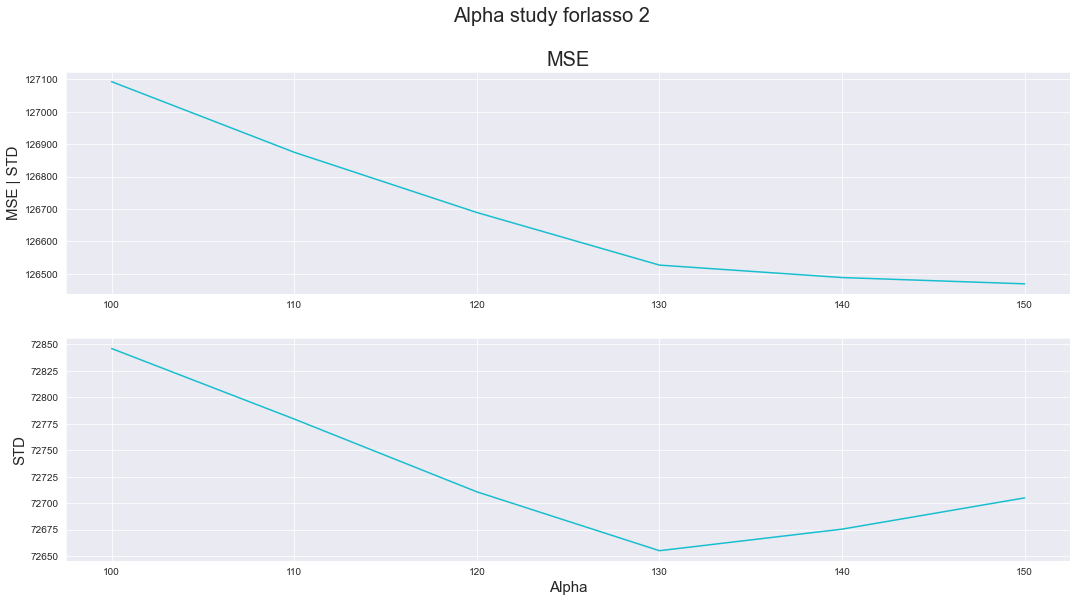

In [161]:
results = lasso_alpha_test([100, 110, 120, 130, 140, 150])
plot_result_alpha(results, "lasso 2")